In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypsa
import seaborn as sb
from glob import glob
import os
import sys
from pathlib import Path
from tqdm import tqdm

c:\users\sdotson\research\ucsmpl\UCSmpl\__init__.py:2: DeprecationWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html



In [2]:
results_path = Path('../results/')

In [3]:
networks_list = glob(str(results_path/'**'/'networks'/'*.nc'))
networks_list = [file for file in networks_list if "old_results" not in file]
networks_list

['..\\results\\cost-2018_growth-0.01_demand-1.36E+08_atb-Moderate_v11.0\\networks\\illinois_solved.nc',
 '..\\results\\cost-2018_growth-0.01_demand-1.85E+08_atb-Moderate_v11.0\\networks\\illinois_solved.nc',
 '..\\results\\cost-2018_growth-0_demand-1.36E+08_atb-Moderate_v11.0\\networks\\illinois_solved.nc',
 '..\\results\\cost-2018_growth-0_demand-1.85E+08_atb-Moderate_v11.0\\networks\\illinois_solved.nc',
 '..\\results\\cost-2019_growth-0.01_demand-1.36E+08_atb-Moderate_v11.0\\networks\\illinois_solved.nc',
 '..\\results\\cost-2019_growth-0.01_demand-1.85E+08_atb-Moderate_v11.0\\networks\\illinois_solved.nc',
 '..\\results\\cost-2019_growth-0_demand-1.36E+08_atb-Moderate_v11.0\\networks\\illinois_solved.nc',
 '..\\results\\cost-2019_growth-0_demand-1.85E+08_atb-Moderate_v11.0\\networks\\illinois_solved.nc',
 '..\\results\\cost-2020_growth-0.01_demand-1.36E+08_atb-Moderate_v11.0\\networks\\illinois_solved.nc',
 '..\\results\\cost-2020_growth-0.01_demand-1.85E+08_atb-Moderate_v11.0\\net

In [4]:
def get_active_units(n):
    c = "StorageUnit"
    df = pd.concat(
        {
            period: n.get_active_assets(c, period) * n.df(c).p_nom_opt
            for period in n.investment_periods
        },
        axis=1,
    )
    df = df.groupby(n.storage_units.carrier).sum()

    c = "Generator"
    df2 = pd.concat(
        {
            period: n.get_active_assets(c, period) * n.df(c).p_nom_opt
            for period in n.investment_periods
        },
        axis=1,
    )
    df2 = df2.groupby(n.generators.carrier).sum()
    df = pd.concat([df, df2])
    
    return df

In [20]:
frames = []
for network in tqdm(networks_list, leave=False):
    parameters = network.split('\\')[2].split('_')
    
    n = pypsa.Network(network)
    
    data = get_active_units(n).T
    
    for i, param in enumerate(parameters[:-1]):
        value = param.split('-')[1]
        if i == 0:
            data['fuel_cost_year'] = value
        elif i==1:
            data['growth'] = value
        elif i==2:
            if float(value) > 180e6:
                data['export'] = 'yes'
            else:
                data['export'] = 'no'
        elif i==3:
            data['atb_case'] = 'value'
    frames.append(data)

 96%|█████████▌| 23/24 [06:39<00:16, 16.76s/it]INFO:pypsa.io:Imported network illinois_solved.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units


In [21]:
frames[0]

carrier,Batteries,Biomass,Coal,Natural Gas,Nuclear,Petroleum,Solar,Wind,fuel_cost_year,growth,export,atb_case
2030,972.623032,0.0,4310.6,18905.2,12415.1,0.0,1232.600000,7901.900000,2018,0.01,no,value
2035,1073.689019,0.0,4310.6,14709.2,12415.1,0.0,1232.600000,2962.273727,2018,0.01,no,value
2040,14888.017866,0.0,0.0,6008.2,12415.1,0.0,17568.930663,11507.865851,2018,0.01,no,value
2045,33598.266026,0.0,0.0,5306.1,12415.1,0.0,53050.596634,27752.094478,2018,0.01,no,value
2050,33496.900040,0.0,0.0,0.0,12415.1,0.0,53050.596634,34913.244836,2018,0.01,no,value


In [22]:
cap = pd.concat(frames, axis=0).reset_index()

In [23]:
cap = cap.rename(columns={'index':'year'})

In [24]:
cap

carrier,year,Batteries,Biomass,Coal,Natural Gas,Nuclear,Petroleum,Solar,Wind,fuel_cost_year,growth,export,atb_case
0,2030,972.623032,0.0,4310.6,18905.2,12415.1,0.0,1232.600000,7901.900000,2018,0.01,no,value
1,2035,1073.689019,0.0,4310.6,14709.2,12415.1,0.0,1232.600000,2962.273727,2018,0.01,no,value
2,2040,14888.017866,0.0,0.0,6008.2,12415.1,0.0,17568.930663,11507.865851,2018,0.01,no,value
3,2045,33598.266026,0.0,0.0,5306.1,12415.1,0.0,53050.596634,27752.094478,2018,0.01,no,value
4,2050,33496.900040,0.0,0.0,0.0,12415.1,0.0,53050.596634,34913.244836,2018,0.01,no,value
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2030,0.300000,0.0,4310.6,18905.2,12415.1,0.0,13225.277260,16792.586153,2023,0,yes,value
116,2035,4333.232871,0.0,4310.6,14709.2,12415.1,0.0,13225.277260,13532.726925,2023,0,yes,value
117,2040,28811.115739,0.0,0.0,6008.2,12415.1,0.0,30485.105224,25082.500728,2023,0,yes,value
118,2045,47465.983143,0.0,0.0,5306.1,12415.1,0.0,67053.762174,40998.460937,2023,0,yes,value


In [25]:
battery_cap = cap.pivot_table(index=['growth','export', 'fuel_cost_year'],
                columns=['year'],
                values='Batteries')

In [26]:
battery_cap_flat =battery_cap.reset_index()

In [27]:
cap['year'] = cap['year'].astype('int')

In [41]:
def linear_growth(init_value, start_year, growth_rate, end_year=2050):
    def model(x, init_val, start, rate):
        return rate * init_val * (x - start) + init_val
    years = np.arange(start_year, end_year, 1).astype('int')
    growth_data = model(years, init_value, start_year, growth_rate)

    growth_df = pd.DataFrame({'demand': growth_data})
    growth_df.index = pd.date_range(start=str(start_year),
                                    periods=(end_year - start_year),
                                    freq='YE')

    return growth_df

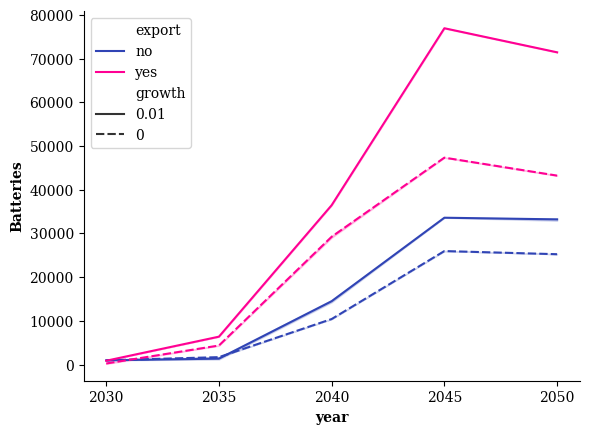

In [63]:
with plt.style.context('ucs_light'):
    fig, ax = plt.subplots()
    sb.lineplot(data=cap, x='year',y='Batteries', hue='export', style='growth')
    
    ax.set_xticks(cap.year.unique())
    # ax.set_yticks()

In [73]:
# cap.to_csv("capacity_results.csv")

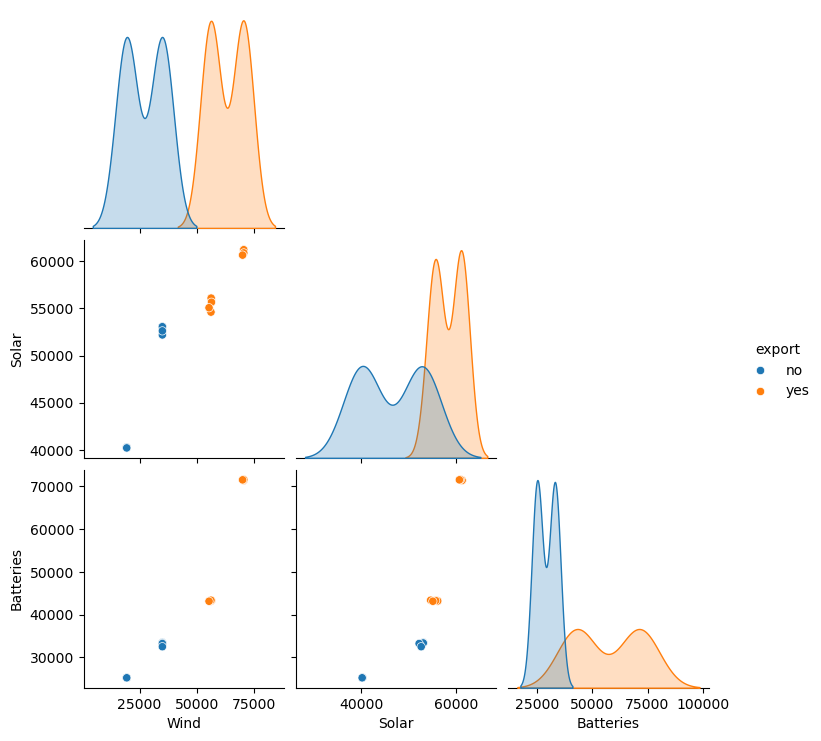

In [69]:
sb.pairplot(data=cap.loc[cap['year']==2050, ['Wind', 'Solar', 'Batteries','export']], hue='export', corner=True)

In [74]:
test_network = pypsa.Network(networks_list[0])

INFO:pypsa.io:Imported network illinois_solved.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units


In [75]:
TECH_ORDER = ['Nuclear',
              'Coal',
              'Natural Gas',
              'Biomass',
              'Petroleum',
              'Wind',
              'Solar',
              ]
def power_by_carrier(n):
    p_by_carrier = n.generators_t.p.T.groupby(
        n.generators.carrier).sum().T 
    
    if not n.storage_units.empty:
        sto = n.storage_units_t.p.T.clip(lower=0).groupby(
            n.storage_units.carrier).sum().T
        p_by_carrier = pd.concat([p_by_carrier, sto], axis=1)
        
    last_cols = [col for col in p_by_carrier.columns if col not in TECH_ORDER]

    p_by_carrier = p_by_carrier[TECH_ORDER+last_cols]

    return p_by_carrier

In [84]:
pbc = power_by_carrier(test_network).resample('YE',level='timestep').sum().replace(0, np.nan).dropna(how='all', axis=0).fillna(0)

In [106]:
pbc.index = pbc.index.year

In [107]:
pbc

carrier,Nuclear,Coal,Natural Gas,Biomass,Petroleum,Wind,Solar,Batteries
timestep,,,,,,,,
2030,1.049315e+08,3.222303e+06,8.167624e+06,0.0,0.0,1.801892e+07,1.659649e+06,2.154967e+06
2035,1.079255e+08,4.263667e+06,2.007739e+07,0.0,0.0,8.284770e+06,1.848658e+06,1.952532e+06
2040,1.016369e+08,0.000000e+00,4.006726e+06,0.0,0.0,2.435938e+07,1.963346e+07,1.922535e+07
2045,9.803149e+07,0.000000e+00,0.000000e+00,0.0,0.0,2.792997e+07,3.041681e+07,4.258172e+07
2050,9.794443e+07,0.000000e+00,0.000000e+00,0.0,0.0,3.337891e+07,3.226193e+07,4.162270e+07


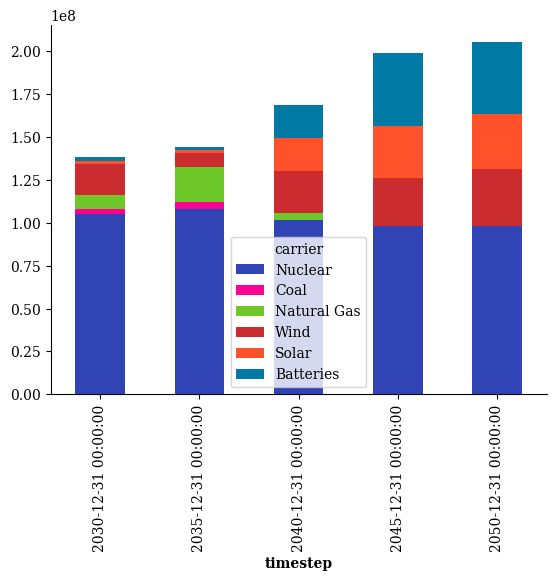

In [102]:
with plt.style.context('ucs_light'):
    fig, ax = plt.subplots()
    pbc.drop(columns=['Biomass', 'Petroleum']).plot.bar(ax=ax,stacked= True)
    # test_network.loads_t.p_set.resample('YE',level='timestep').sum().replace(0,np.nan).dropna(how='all', axis=0).fillna(0).sum(axis=1).plot(ax=ax, color='k', marker='.')

In [136]:
frames = []
for network in tqdm(networks_list, leave=False):
    parameters = network.split('\\')[2].split('_')
    
    n = pypsa.Network(network)
    
    data = power_by_carrier(n).resample('YE',level='timestep').sum().replace(0, np.nan).dropna(how='all', axis=0).fillna(0)
    
    data.index = data.index.year
    
    for i, param in enumerate(parameters[:-1]):
        value = param.split('-')[1]
        if i == 0:
            data['fuel_cost_year'] = value
        elif i==1:
            data['growth'] = value
        elif i==2:
            if float(value) > 180e6:
                data['export'] = 'yes'
            else:
                data['export'] = 'no'
        elif i==3:
            data['atb_case'] = 'moderate'
    frames.append(data)

 96%|█████████▌| 23/24 [07:51<00:18, 18.70s/it]INFO:pypsa.io:Imported network illinois_solved.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units


In [137]:
gen = pd.concat(frames, axis=0)
gen

carrier,Nuclear,Coal,Natural Gas,Biomass,Petroleum,Wind,Solar,Batteries,fuel_cost_year,growth,export,atb_case
timestep,,,,,,,,,,,,
2030,1.049315e+08,3.222303e+06,8.167624e+06,0.0,0.0,1.801892e+07,1.659649e+06,2.154967e+06,2018,0.01,no,moderate
2035,1.079255e+08,4.263667e+06,2.007739e+07,0.0,0.0,8.284770e+06,1.848658e+06,1.952532e+06,2018,0.01,no,moderate
2040,1.016369e+08,0.000000e+00,4.006726e+06,0.0,0.0,2.435938e+07,1.963346e+07,1.922535e+07,2018,0.01,no,moderate
2045,9.803149e+07,0.000000e+00,0.000000e+00,0.0,0.0,2.792997e+07,3.041681e+07,4.258172e+07,2018,0.01,no,moderate
2050,9.794443e+07,0.000000e+00,0.000000e+00,0.0,0.0,3.337891e+07,3.226193e+07,4.162270e+07,2018,0.01,no,moderate
...,...,...,...,...,...,...,...,...,...,...,...,...
2030,1.061454e+08,4.263667e+06,1.766106e+07,0.0,0.0,4.132053e+07,1.560937e+07,1.145763e+03,2023,0,yes,moderate
2035,1.060370e+08,4.263667e+06,2.007739e+07,0.0,0.0,3.625430e+07,1.784937e+07,8.063830e+06,2023,0,yes,moderate
2040,1.002995e+08,0.000000e+00,3.605942e+06,0.0,0.0,5.105366e+07,3.010957e+07,3.422404e+07,2023,0,yes,moderate


In [138]:
gen.to_csv("annual_generation_results.csv")

In [139]:
gen = gen.reset_index()
gen

carrier,timestep,Nuclear,Coal,Natural Gas,Biomass,Petroleum,Wind,Solar,Batteries,fuel_cost_year,growth,export,atb_case
0,2030,1.049315e+08,3.222303e+06,8.167624e+06,0.0,0.0,1.801892e+07,1.659649e+06,2.154967e+06,2018,0.01,no,moderate
1,2035,1.079255e+08,4.263667e+06,2.007739e+07,0.0,0.0,8.284770e+06,1.848658e+06,1.952532e+06,2018,0.01,no,moderate
2,2040,1.016369e+08,0.000000e+00,4.006726e+06,0.0,0.0,2.435938e+07,1.963346e+07,1.922535e+07,2018,0.01,no,moderate
3,2045,9.803149e+07,0.000000e+00,0.000000e+00,0.0,0.0,2.792997e+07,3.041681e+07,4.258172e+07,2018,0.01,no,moderate
4,2050,9.794443e+07,0.000000e+00,0.000000e+00,0.0,0.0,3.337891e+07,3.226193e+07,4.162270e+07,2018,0.01,no,moderate
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2030,1.061454e+08,4.263667e+06,1.766106e+07,0.0,0.0,4.132053e+07,1.560937e+07,1.145763e+03,2023,0,yes,moderate
116,2035,1.060370e+08,4.263667e+06,2.007739e+07,0.0,0.0,3.625430e+07,1.784937e+07,8.063830e+06,2023,0,yes,moderate
117,2040,1.002995e+08,0.000000e+00,3.605942e+06,0.0,0.0,5.105366e+07,3.010957e+07,3.422404e+07,2023,0,yes,moderate
118,2045,9.805979e+07,0.000000e+00,0.000000e+00,0.0,0.0,4.837446e+07,3.855960e+07,5.677830e+07,2023,0,yes,moderate


In [149]:
data = gen.melt(id_vars=['timestep','export','growth'],
                value_vars=['Batteries','Coal','Natural Gas','Nuclear','Solar','Wind'])

In [150]:
data

,timestep,export,growth,carrier,value
0,2030,no,0.01,Batteries,2.154967e+06
1,2035,no,0.01,Batteries,1.952532e+06
2,2040,no,0.01,Batteries,1.922535e+07
3,2045,no,0.01,Batteries,4.258172e+07
4,2050,no,0.01,Batteries,4.162270e+07
...,...,...,...,...,...
715,2030,yes,0,Wind,4.132053e+07
716,2035,yes,0,Wind,3.625430e+07
717,2040,yes,0,Wind,5.105366e+07
718,2045,yes,0,Wind,4.837446e+07


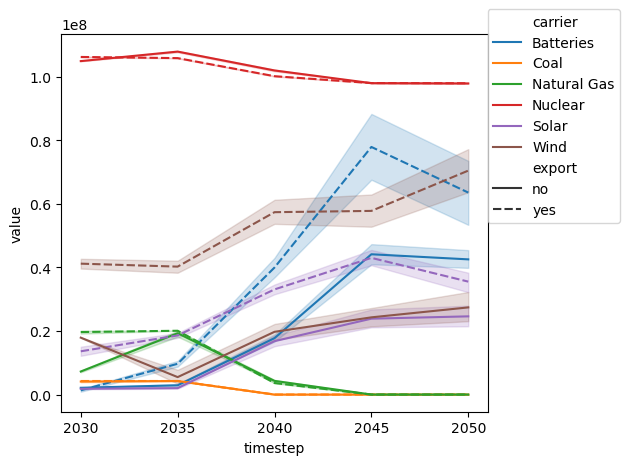

In [157]:
ax = sb.lineplot(data=data, x='timestep', y='value', hue='carrier', style='export')
ax.legend(loc=(1,0.5))
ax.set_xticks(data['timestep'].unique())
plt.tight_layout()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


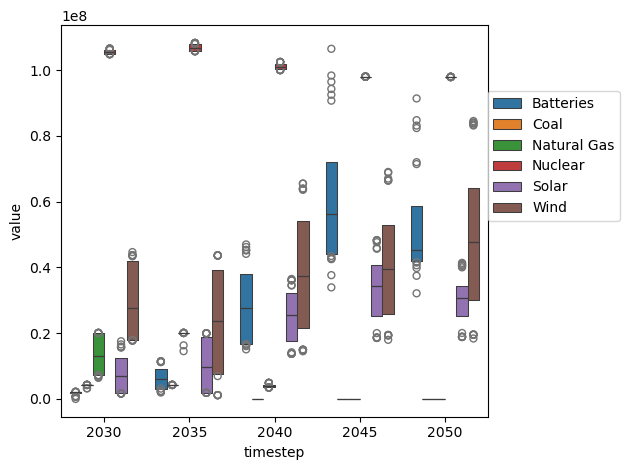

In [151]:
ax = sb.boxenplot(data=data, x='timestep', y='value', hue='carrier')
ax.legend(loc=(1,0.5))
plt.tight_layout()

In [173]:
test_network = pypsa.Network('../results/itc-test-run_v1.1/networks/illinois_solved.nc')

INFO:pypsa.io:Imported network illinois_solved.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units


In [175]:
get_active_units(test_network)

,2030,2035,2040,2045,2050
carrier,,,,,
Batteries,794.724298,6467.916574,35876.548239,77762.193437,72088.701160
Biomass,0.000000,0.000000,0.000000,0.000000,0.000000
Coal,4310.600000,4310.600000,0.000000,0.000000,0.000000
Natural Gas,18905.200000,14709.200000,6008.200000,5306.100000,0.000000
Nuclear,12415.100000,12415.100000,12415.100000,12415.100000,12415.100000
Petroleum,0.000000,0.000000,0.000000,0.000000,0.000000
Solar,9630.494029,14376.184305,39461.646684,67270.036610,58872.142581
Wind,20461.368251,16521.378149,32299.059466,48863.198814,68761.563803


In [171]:
cap.dtypes

carrier
year                int32
Batteries         float64
Biomass           float64
Coal              float64
Natural Gas       float64
Nuclear           float64
Petroleum         float64
Solar             float64
Wind              float64
fuel_cost_year     object
growth             object
export             object
atb_case           object
dtype: object

In [172]:
cap.drop(columns=['fuel_cost_year']).groupby(['export','growth','year','atb_case']).mean()

carrier                         Batteries  Biomass    Coal  Natural Gas  \
export growth year atb_case                                               
no     0      2030 value       972.623032      0.0  4310.6      18905.2   
              2035 value      1692.836263      0.0  4310.6      14709.2   
              2040 value     10414.658259      0.0     0.0       6008.2   
              2045 value     25968.858420      0.0     0.0       5306.1   
              2050 value     25248.345189      0.0     0.0          0.0   
       0.01   2030 value       972.623032      0.0  4310.6      18905.2   
              2035 value      1348.824637      0.0  4310.6      14709.2   
              2040 value     14494.734427      0.0     0.0       6008.2   
              2045 value     33598.266026      0.0     0.0       5306.1   
              2050 value     33221.764422      0.0     0.0          0.0   
yes    0      2030 value       242.246793      0.0  4310.6      18905.2   
              2035 value      4352.957894      0.0  4310.6      14709.2   
              2040 value     29243.840550      0.0     0.0       6008.2   
              2045 value     47345.027407      0.0     0.0       5306.1   
              2050 value     43234.016307      0.0     0.0          0.0   
       0.01   2030 value       872.103111      0.0  4310.6      18905.2   
              2035 value      6379.637712      0.0  4310.6      14709.2   
              2040 value     36468.699518      0.0     0.0       6008.2   
              2045 value     76958.007073      0.0     0.0       5306.1   
              2050 value     71450.172473      0.0     0.0          0.0   

carrier                      Nuclear  Petroleum         Solar          Wind  
export growth year atb_case                                                  
no     0      2030 value     12415.1        0.0   1241.467977   7901.900000  
              2035 value     12415.1        0.0   1241.467977    797.794016  
              2040 value     12415.1        0.0  12377.473102   6367.491210  
              2045 value     12415.1        0.0  40272.186634  19354.019433  
              2050 value     12415.1        0.0  40263.318657  19354.019433  
       0.01   2030 value     12415.1        0.0   1450.604297   7901.900000  
              2035 value     12415.1        0.0   1450.604297   3095.876377  
              2040 value     12415.1        0.0  18302.569551  11475.417966  
              2045 value     12415.1        0.0  53050.596634  27752.094478  
              2050 value     12415.1        0.0  52832.592337  34913.244836  
yes    0      2030 value     12415.1        0.0  12772.927115  15111.992813  
              2035 value     12415.1        0.0  12772.927115  13814.843123  
              2040 value     12415.1        0.0  29514.748938  25247.752918  
              2045 value     12415.1        0.0  67111.257045  41172.668553  
              2050 value     12415.1        0.0  55570.929930  56074.112907  
       0.01   2030 value     12415.1        0.0   7940.343309  17705.813360  
              2035 value     12415.1        0.0  15518.821692  15874.368683  
              2040 value     12415.1        0.0  37221.031307  32973.377177  
              2045 value     12415.1        0.0  67759.334988  49386.721752  
              2050 value     12415.1        0.0  61051.591679  70365.961840

In [176]:
adv_nuc_1 = pypsa.Network("../results/advanced_nuclear_v1.0/networks/illinois_solved.nc")
adv_nuc_2 = pypsa.Network("../results/advanced_nuclear_v1.1/networks/illinois_solved.nc")

INFO:pypsa.io:Imported network illinois_solved.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units
INFO:pypsa.io:Imported network illinois_solved.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units


In [181]:
(get_active_units(adv_nuc_1).loc['Nuclear'] - 12415.1)/1e3

2030   -1.818989e-15
2035    5.134455e-01
2040    8.722921e+00
2045    1.497713e+01
2050    1.497713e+01
Name: Nuclear, dtype: float64

In [188]:
test_network = pypsa.Network(networks_list[22])

INFO:pypsa.io:Imported network illinois_solved.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units


In [183]:
(get_active_units(adv_nuc_2).loc['Nuclear'] - 12415.1)/1e3

2030   -1.818989e-15
2035   -1.818989e-15
2040    3.145303e+00
2045    8.471798e+00
2050    8.471798e+00
Name: Nuclear, dtype: float64

In [200]:
total_energy = adv_nuc_2.loads_t.p_set.sum().sum()

In [204]:
adv_nuc_2.objective / total_energy

198.36782078274578

In [206]:
test_network.objective / test_network.loads_t.p_set.sum().sum()

262.69810733120016

In [208]:
from unyt import MWh, kWh

In [207]:
262.7 - 198.4

64.29999999999998

In [205]:
adv_nuc_1.objective / adv_nuc_1.loads_t.p_set.sum().sum()

266.2221509761428

In [210]:
get_active_units(adv_nuc_1)

,2030,2035,2040,2045,2050
carrier,,,,,
Batteries,704.369372,5414.500577,16651.214536,23299.008012,18588.576807
Biomass,0.000000,0.000000,0.000000,0.000000,0.000000
Coal,4310.600000,4310.600000,0.000000,0.000000,0.000000
Natural Gas,18905.200000,14709.200000,6008.200000,5306.100000,0.000000
Nuclear,12415.100000,12928.545505,21138.020599,27392.225101,27392.225101
Petroleum,0.000000,0.000000,0.000000,0.000000,0.000000
Solar,8837.780304,14992.120345,18047.742605,30116.319387,22511.139083
Wind,16868.932525,14000.343592,14000.343592,14000.343592,21661.994470
